# Sox2 analysis

## Generate environment

```bash
conda create -n scFates -c conda-forge -c r python=3.8 r-mgcv rpy2 -y
conda activate scFates
pip install scFates
```

## Data download

In [1]:
%%bash
mkdir -p figures
wget -nv https://ftp.ncbi.nlm.nih.gov/geo/series/GSE201nnn/GSE201257/suppl/GSE201257%5Fadata%5Fassigned%2Eh5ad%2Egz
wget -nv https://ftp.ncbi.nlm.nih.gov/geo/series/GSE201nnn/GSE201257/suppl/GSE201257%5Fadata%5Fglia%5Ffocus%2Eh5ad%2Egz
wget -nv https://ftp.ncbi.nlm.nih.gov/geo/series/GSE201nnn/GSE201257/suppl/GSE201257%5Fadata%5Fscenic%2Eh5ad%2Egz
wget -nv https://ftp.ncbi.nlm.nih.gov/geo/series/GSE201nnn/GSE201257/suppl/GSE201257%5Fadata%5Ftree%2Eh5ad%2Egz
gunzip *.gz

2023-07-12 16:28:33 URL:https://ftp.ncbi.nlm.nih.gov/geo/series/GSE201nnn/GSE201257/suppl/GSE201257%5Fadata%5Fassigned%2Eh5ad%2Egz [2485692029/2485692029] -> "GSE201257_adata_assigned.h5ad.gz" [1]
2023-07-12 16:29:23 URL:https://ftp.ncbi.nlm.nih.gov/geo/series/GSE201nnn/GSE201257/suppl/GSE201257%5Fadata%5Fglia%5Ffocus%2Eh5ad%2Egz [468056956/468056956] -> "GSE201257_adata_glia_focus.h5ad.gz" [1]
2023-07-12 16:29:30 URL:https://ftp.ncbi.nlm.nih.gov/geo/series/GSE201nnn/GSE201257/suppl/GSE201257%5Fadata%5Fscenic%2Eh5ad%2Egz [28461296/28461296] -> "GSE201257_adata_scenic.h5ad.gz" [1]
2023-07-12 16:32:43 URL:https://ftp.ncbi.nlm.nih.gov/geo/series/GSE201nnn/GSE201257/suppl/GSE201257%5Fadata%5Ftree%2Eh5ad%2Egz [2622031311/2622031311] -> "GSE201257_adata_tree.h5ad.gz" [1]


## Analysis

In [2]:
import os, sys
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"
import scanpy as sc
import matplotlib.pyplot as plt
import scvelo as scv
import scFates as scf
scv.set_figure_params(figsize=(3,3))
scf.set_figure_pubready()

In [3]:
adata=sc.read("GSE201257_adata_assigned.h5ad")

<AxesSubplot:>

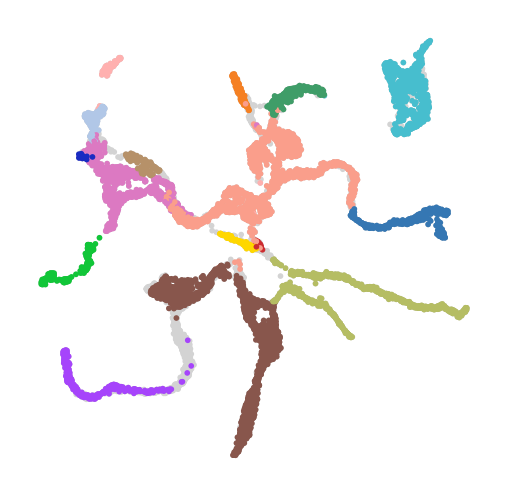

In [4]:
markers={"BCC":["Prss56","Egr2","Wif1","Hey2"],
    "ChC":["Th","Dbh","Chga","Chgb","Slc18a1","Slc18a2"],
         "enteric glia":["Phox2b","Ctgf","Nfia","Tgfb2","S100b"],
         "enteric neu.":["Ret", "Phox2a", "Chrna3","Sox11"],
         "melanocytes":["Dct","Mitf","Pmel","Tyr"],
         "mesenchyme":["Prrx1","Prrx2","Pdgfra"],
         "neural crest":["Sox9","Wnt1","Ets1"],
         "SC":["Mpz","Plp1","Fbxo7","Gjc3","Pmp22","Dhh","Mal"],
         "sat. glia":["Fabp7","Ptn","Rgcc"],
         "sens. neu.":["Prdm12","Isl2","Pou4f1","Six1"],
         "symp. neu.":["Cartpt","Prph","Mapt","Maoa"],
         "endo. fib.":["Lum","Dcn","Fbn1"],
         }

adata.obs.assignments=adata.obs.assignments.cat.rename_categories(list(markers.keys())+["none"])

celltypes=list(markers.keys())

txts=["\n"+"\n".join(markers[a]) for a in celltypes]

txts[-1]="\n"+txts[-1]

adata.obs.assignments.cat.categories

import pandas as pd
centers=pd.DataFrame([adata[adata.obs.assignments==a].obsm["X_umap"].mean(axis=0).tolist() for a in celltypes],
            columns=["x","y"])

cols=dict(zip(celltypes,adata.uns["assignments_colors"]))

cols

def annotate(x,y,ha,i):
    ax.text(x, y, celltypes[i], va="top", ha=ha,fontsize=4,transform=ax.transAxes,
        c=cols[ celltypes[i]],fontdict={"fontweight":"bold"})
    ax.text(x, y, "%s"%txts[i], va="top", ha=ha,fontsize=4,transform=ax.transAxes,
           fontdict={"fontstyle":"italic"})

dat=adata[adata.obs.Hub_leiden=="True"].obsm["X_umap"]


adata_glia=sc.read("GSE201257_adata_glia_focus.h5ad")

adata.obs.assignments=adata.obs.assignments.astype(str)


adata.obs.loc[adata_glia.obs_names[adata_glia.obs.milestones=="tSC"],"assignments"]="tSC"
adata.obs.loc[adata_glia.obs_names[adata_glia.obs.milestones=="nmSC"],"assignments"]="nmSC"
adata.obs.loc[adata_glia.obs_names[adata_glia.obs.milestones=="mSC"],"assignments"]="mSC"

adata.obs.assignments=adata.obs.assignments.astype("category")

adata_glia.uns["milestones_colors"][adata_glia.obs.milestones.cat.categories=="mSC"][0]

cols["tSC"]="#b69169"
cols["mSC"]="#192bc2"
cols["nmSC"]=adata_glia.uns["milestones_colors"][adata_glia.obs.milestones.cat.categories=="nmSC"][0]
cols["none"]="lightgrey"
cols["endoneurial\nfibroblasts"]="#d33f6a"

celltypes.append("tSC")
celltypes.append("mSC")
celltypes.append("nmSC")

import numpy as np
adata.uns["assignments_colors"]=[cols[a] for a in adata.obs.assignments.cat.categories]

adata_new=sc.AnnData.concatenate(adata[adata.obs.assignments!="mSC"],
                                 adata[adata.obs.assignments=="mSC"],index_unique=None)
adata_new.obs.assignments=adata.obs.assignments.loc[adata_new.obs_names]


adata_new.uns["assignments_colors"]=[cols[a] for a in adata.obs.assignments.cat.categories]



adata_new.obs.assignments.cat.add_categories("Hub",inplace=True)
adata_new.obs.loc[adata[adata.obs.Hub_leiden=="True"].obs_names,"assignments"]="Hub"

adata_new.uns["assignments_colors"].append("#fa9e8b")

scv.pl.umap(adata_new,color="assignments",legend_loc="none",title="",rasterized=False,
              groups=celltypes+["Hub"],show=False)

In [5]:
# Fast spearman correlations based on https://saket-choudhary.me/blog/2022/03/09/sparsespearman/
import scipy.sparse as sparse
import scipy.stats as stats
from scipy.sparse import csc_matrix
import numpy as np
from numba import jit


def cor_sparse_pearson(X, Y=None, cov=False):
    if not sparse.issparse(X):
      # should be CSC
      X = csc_matrix(X)
    nrows = X.shape[0]
    meanX = X.mean(axis=0)
    if Y is None:
        covmat = X.T * X - nrows * meanX.T * meanX
        covmat = covmat / (nrows - 1)
        var = np.outer(np.diag(covmat), np.diag(covmat))
        cormat = np.divide(covmat, np.sqrt(var))
    else:
        if X.shape[0] != Y.shape[0]:
            raise RuntimeError("X and Y have different # of columns")
        if not sparse.issparse(Y):
            Y = csc_matrix(Y)
        meanY = Y.mean(axis=0)
        covmat = X.T * Y - nrows * meanX.T * meanY
        covmat = covmat / (nrows - 1)        
        meanX2 = np.power(meanX, 2)
        meanY2 = np.power(meanY, 2)
        sdX = np.sqrt((X.power(2).sum(axis=0) - nrows * meanX2) / (nrows - 1))
        sdY = np.sqrt((Y.power(2).sum(axis=0) - nrows * meanY2) / (nrows - 1))
        cormat = covmat / (sdX.T * sdY)
    if cov:
        return covmat
    return cormat

def sparsify_ranks(X):
    if not sparse.issparse(X):
        # should be CSC
        X = csc_matrix(X)

    non_zeros_per_col = X.getnnz(axis=0)
    n_zeros_per_col = X.shape[0] - non_zeros_per_col
    offsets = (n_zeros_per_col - 1) / 2

    x = X.data
    nzdata = np.split(x, np.cumsum(non_zeros_per_col))[:-1]
    for index, data in enumerate(nzdata):
        nzdata[index] = offsets[index] + stats.rankdata(data)
    X.data = np.concatenate(nzdata).ravel()
    return X

def cor_sparse_spearman(X, Y=None, cov=None):
    rankX = sparsify_ranks(X)
    if Y is None:
        # Calculate pearson correlation on rank matrices
        return cor_sparse_pearson(X=rankX, cov=cov)
    rankY = sparsify_ranks(Y)
    return cor_sparse_pearson(X=rankX, Y=rankY, cov=cov)



In [6]:
adata_a=sc.read("GSE201257_adata_assigned.h5ad")

In [7]:
res = pd.read_csv("regulon_mat.csv",index_col=0)

In [8]:
adata_scenic=sc.read("GSE201257_adata_scenic.h5ad")

In [9]:
sox2=adata_scenic[:,"Sox2(+)"].layers["auc_init"]

allcors=cor_sparse_spearman(sox2,adata_a.X)
allcors=pd.Series(np.array(allcors)[0],index=adata.var_names)
allcors=allcors.sort_values(ascending=False).to_frame()
allcors.columns=["correlation"]
allcors["regulon"]=False
allcors.loc[res.columns[res.loc["Sox2(+)"]==1],"regulon"]=True


allcors.to_csv("sox2.csv")

In [10]:
adata_a.uns["log1p"]

{'base': 10}

In [11]:
allcors

,correlation,regulon
Fabp7,0.623380,True
Sparc,0.611274,False
Zfp36l1,0.583465,True
Ednrb,0.573613,True
Wwtr1,0.557126,False
...,...,...
Gng3,-0.507876,False
Stmn3,-0.511947,False
Ina,-0.517388,False
Snap25,-0.519682,False


In [12]:
sel=allcors.regulon[::-1]

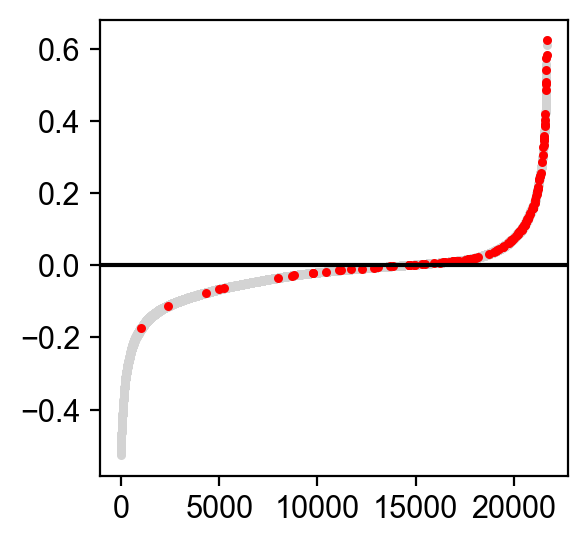

In [13]:
plt.scatter(range(allcors.shape[0]),allcors.correlation[::-1],s=5,marker="o",c="lightgrey")
plt.scatter(np.arange(allcors.shape[0])[sel],allcors.correlation[::-1][sel],s=5,marker="o",c="red")
plt.axhline(0,c="k")

In [14]:
print("\n".join(allcors.index[(allcors.regulon) & (allcors.correlation>0.1)]))

Fabp7
Zfp36l1
Ednrb
Slitrk2
Lmo4
Celf2
Notch1
E130114P18Rik
Id3
Sox2
Cdh10
Col25a1
St5
Ccnd2
Tead2
Pdpn
Arhgef26
Marcks
Pdlim1
Pdcd4
Hmga2
Hoxb9
Arhgef6
Nrarp
Tfap2a
Hes5
Lgr4
Nr2f1
Rassf10
Id2
Sox6
Gtf2h1
Id1
Rhobtb3
Smad3
Cdkn1c
Lfng
Dennd6a
Col22a1
Sh3kbp1
Col23a1
Hey1
Akr1b10
Msi2
Fam198a
Cntrl
Dlg1
Eps15
Calr4
Il25
Arhgef17
Ogt
Ptpn9
Gm11627


In [15]:
print("\n".join(allcors.index[allcors.correlation>.4]))

Fabp7
Sparc
Zfp36l1
Ednrb
Wwtr1
Lama4
Slitrk2
Serpine2
Sox10
Gpr126
Postn
Nid1
Ppic
Lmo4
Ttyh1
Celf2
Spon1
Cyp2j6
Gas7
Rbp1
Afap1l2
Plp1
Ptprz1
Notch1
Slitrk6
Gpx8
Col5a1
Timp3
Foxd3
Gpr17
Mmp14
Mef2c
Cdh19
Itga6
Qk
Erbb3
Sntb1
S100a16
Fstl1
Col18a1
Lamb1
Heyl
Cmtm5
Insc
Serpinh1
Notch2
Col5a2
Plekhb1
Moxd1
Rhbdf1
Dbi
Col4a1
Lima1
Ldhb
Tgfb2
Itga4
E130114P18Rik
Cnp
Pmepa1
Atp1a2
Efemp2
Gpm6b
S100a11
Sox8
Megf10
Luzp2
Mcam
Stard13
Fbxo7
Id3
Gfra1
Bche
Axl
Hspg2


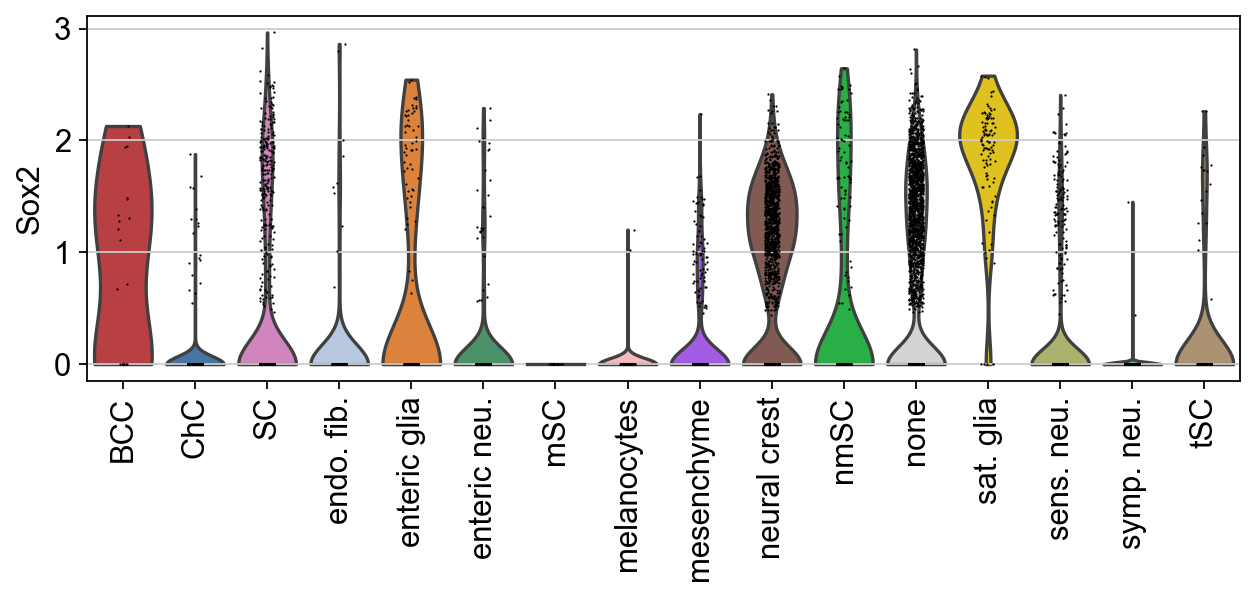

In [16]:
sc.set_figure_params(figsize=(8,3))
sc.pl.violin(adata,"Sox2","assignments",groups=celltypes+["Hub"],rotation=90,swap_axes=True)

In [17]:
adata_scenic.X=adata_scenic.layers["auc_init"]

In [18]:
adata_combi=sc.AnnData.concatenate(adata_new.T,adata_scenic.T,index_unique=None,fill_value=0).T

In [19]:
adata_combi.obs["assignments-0"]

SS2_16_249-2:A1_unique.bam    Hub
SS2_16_249-2:A2_unique.bam    Hub
SS2_16_249-2:A6_unique.bam    Hub
SS2_16_249-2:A3_unique.bam    Hub
SS2_16_249-2:A5_unique.bam    Hub
                             ... 
SS2_19_366:L10_unique.bam     mSC
SS2_19_366:L21_unique.bam     mSC
SS2_19_366:O21_unique.bam     mSC
SS2_19_366:P15_unique.bam     mSC
SS2_19_366:P13_unique.bam     mSC
Name: assignments-0, Length: 8842, dtype: category
Categories (17, object): ['BCC', 'ChC', 'SC', 'endo. fib.', ..., 'sens. neu.', 'symp. neu.', 'tSC', 'Hub']

In [20]:
scf.set_figure_pubready()

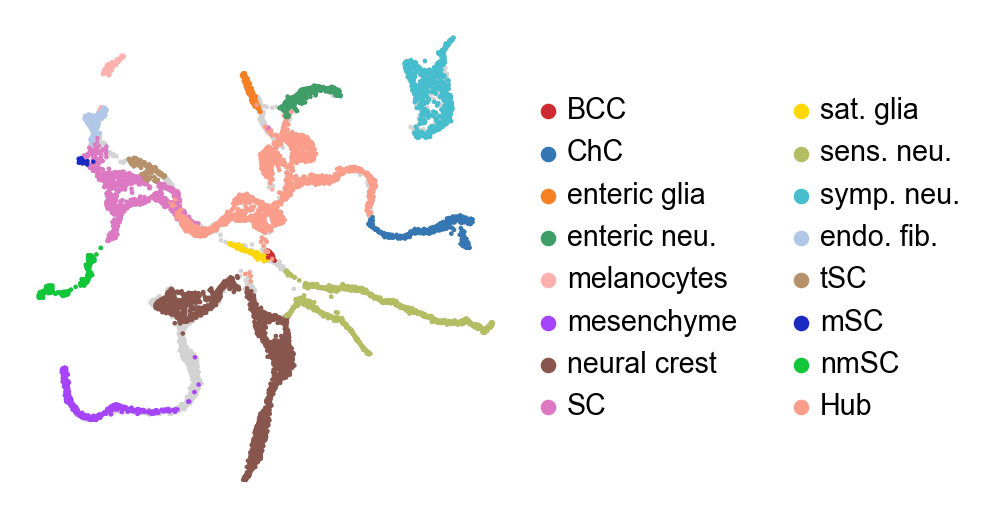

In [21]:
from adjustText import adjust_text
ax=scv.pl.umap(adata_new,color="assignments",title="",legend_loc="right",rasterized=False,
              groups=celltypes+["Hub"],show=False,figsize=(4,4))
ax.grid(b=False)
plt.savefig("figures/Sox2_overview.pdf")

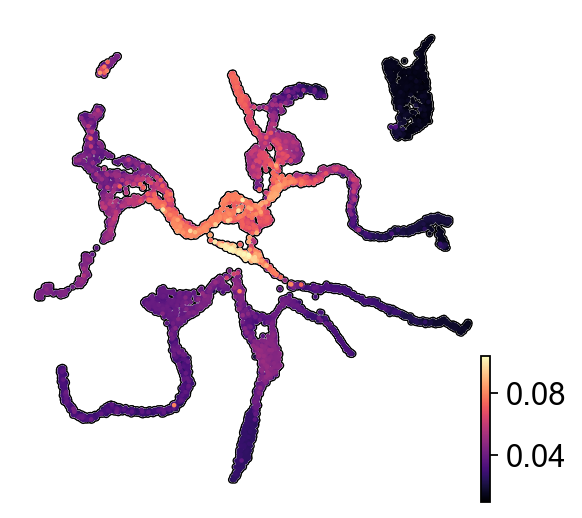

In [22]:
adata_scenic.obsm=adata.obsm
ax=scv.pl.umap(adata_scenic,color="Sox2(+)",cmap="magma",add_outline=True,title="",
               figsize=(3.8,4),smooth=True,show=False)
ax.grid(b=False)
plt.savefig("figures/Sox2_regulon.pdf")

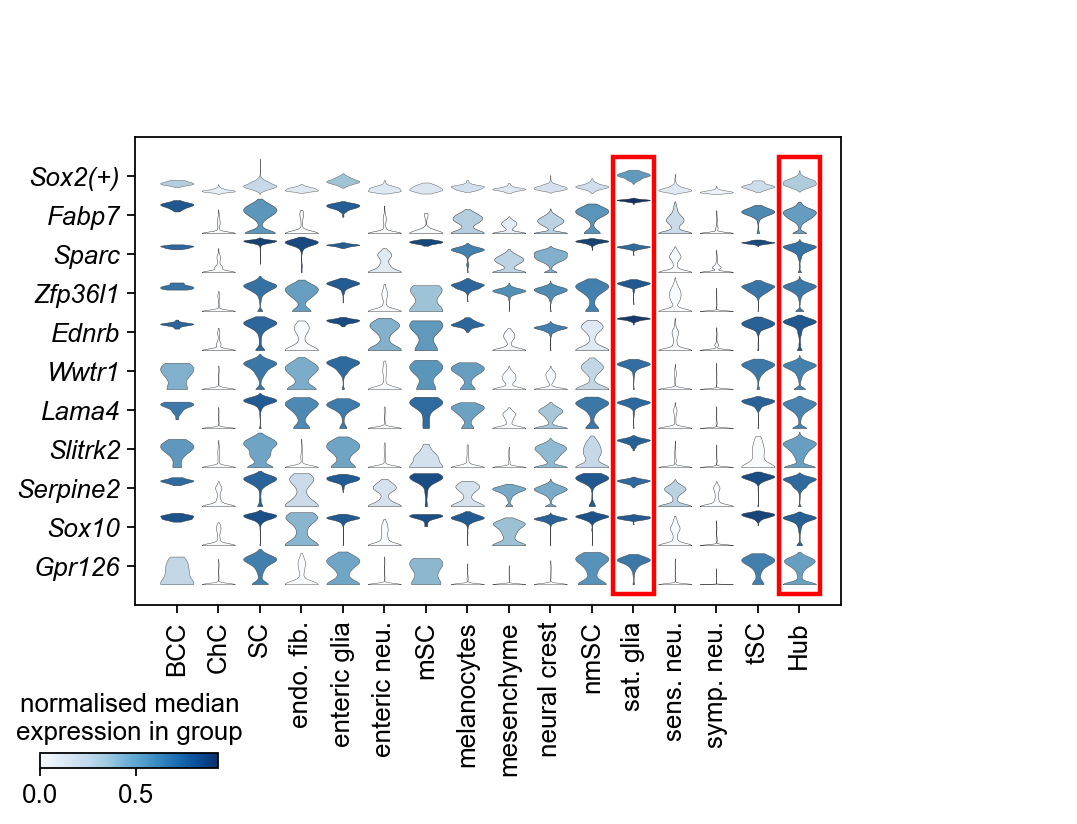

In [23]:
from matplotlib.patches import Rectangle
axs=sc.pl.stacked_violin(adata_combi[adata_combi.obs["assignments-0"]!="none"],
                         ["Sox2(+)"]+pd.read_csv("sox2.csv",index_col=0).index[:10].tolist(),
                     "assignments-0",colorbar_title="normalised median\nexpression in group",
                     standard_scale="var",groups=celltypes+["Hub"],swap_axes=True,show=False)
for txt in axs["mainplot_ax"].get_yticklabels():
    txt.set_fontstyle("italic")
    
axs["mainplot_ax"].add_patch(Rectangle((11, 0), 1, 11.2,
             edgecolor = 'red',
             fill=False,
             lw=2,clip_on=False))

axs["mainplot_ax"].add_patch(Rectangle((15, 0), 1, 11.2,
             edgecolor = 'red',
             fill=False,
             lw=2,clip_on=False))
axs["color_legend_ax"].set_position((0.1,-0.06,0.15,.02))

plt.savefig("figures/Sox2_topcorr.pdf")

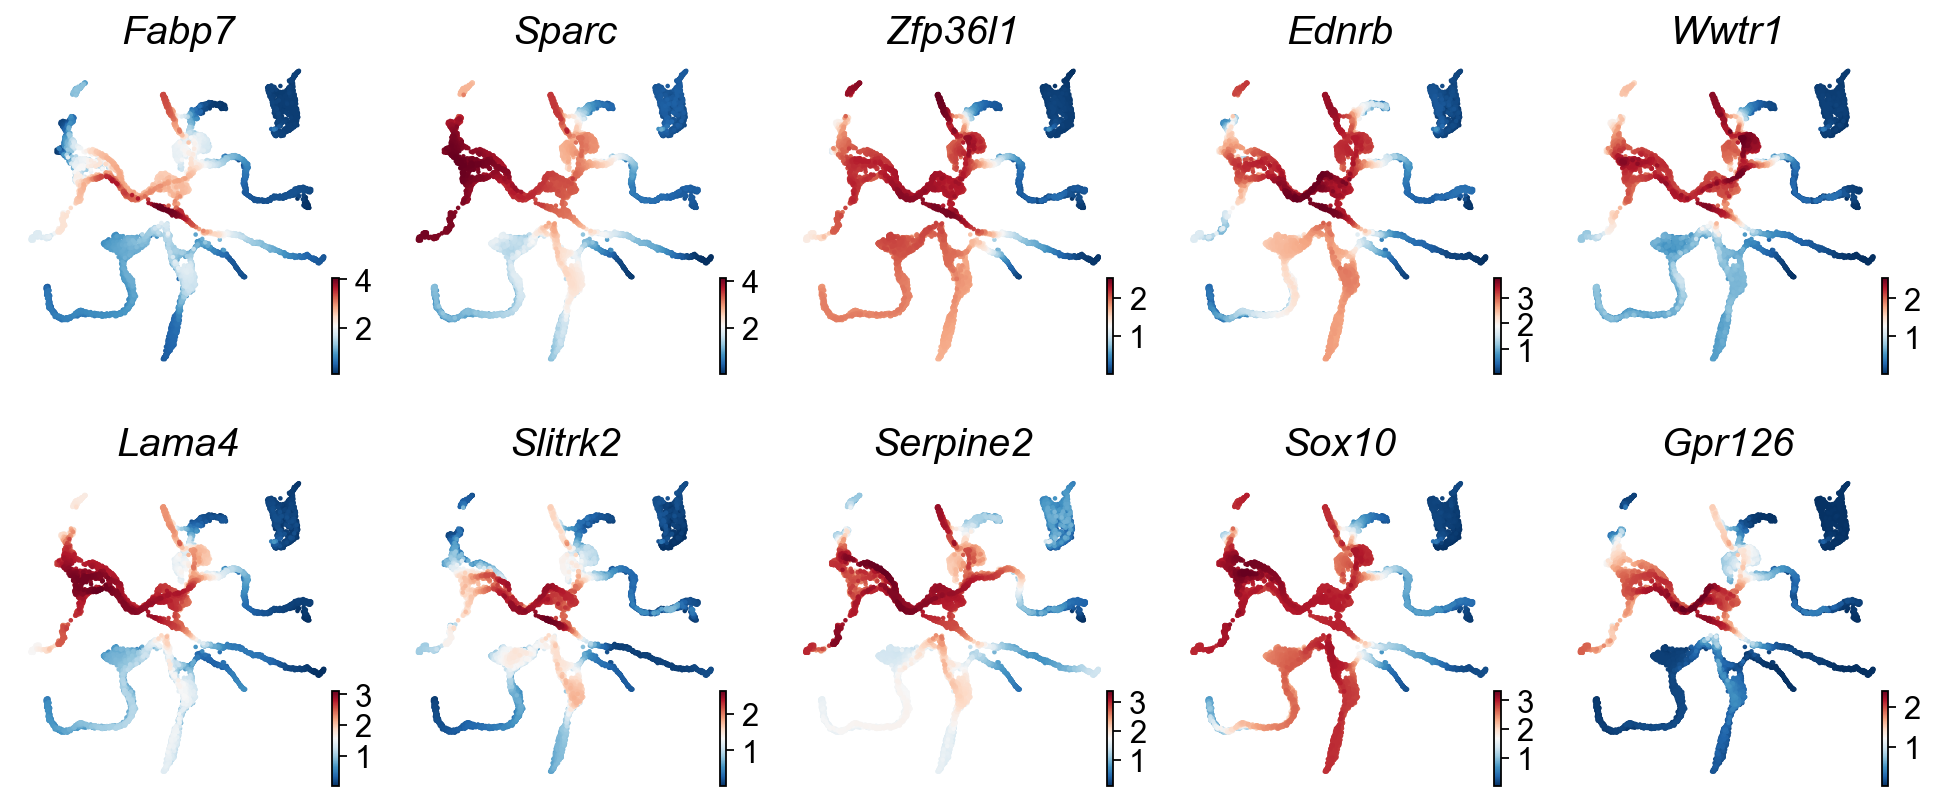

In [24]:
top10=pd.read_csv("sox2.csv",index_col=0).index[:10].tolist()
axs=scv.pl.umap(adata,color=top10,ncols=5,figsize=(3,3),layer="palantir_imp",show=False)
for g,ax in zip(top10,axs):
    ax.grid(b=False)
    ax.set_title(g,style="italic",fontsize=18)
plt.savefig("figures/Sox2_topcorr_umap.pdf")

In [32]:
adata_tree=sc.read("GSE201257_adata_tree.h5ad")

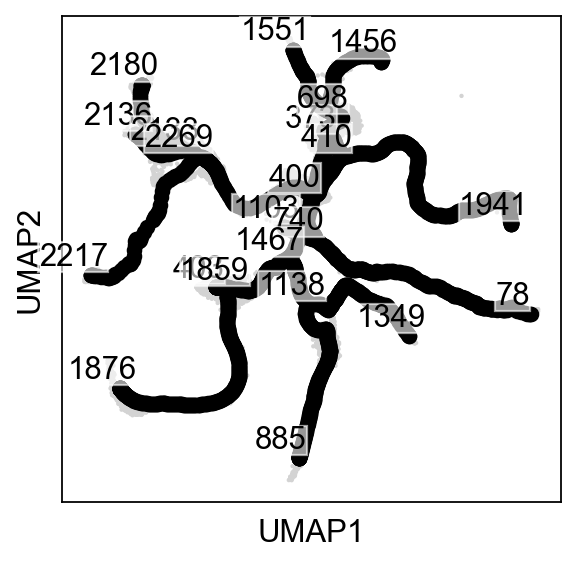

In [33]:
sc.set_figure_params()
scf.pl.graph(adata_tree)

In [34]:
adata_tree.uns["graph"]["method"]="ppt"

In [35]:
scf.tl.subset_tree(adata_tree,root_milestone="Convergence",milestones=["ChC"])

subsetting tree
node 400 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:01) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.
    finished (0:00:00) --> tree extracted
--> added 
    .obs['old_milestones'], previous milestones from intial tree


In [36]:
adata_ChC=adata_combi[adata_tree.obs_names]

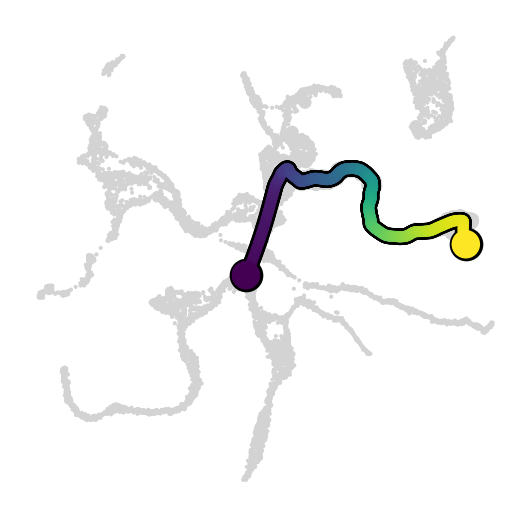

In [37]:
ax=sc.pl.umap(adata,show=False,frameon=False)
scf.pl.trajectory(adata_tree,ax=ax,show=False)
plt.savefig("figures/Sox2_chc_traj.pdf")

In [38]:
sox2=adata_ChC[:,"Sox2(+)"].X

allcors=cor_sparse_spearman(sox2,adata_ChC[:,~adata_ChC.var.ERCC.isna()].X)
allcors=pd.Series(np.array(allcors)[0],index=adata.var_names)
allcors=allcors.sort_values(ascending=False).to_frame()
allcors.columns=["correlation"]
allcors["regulon"]=False
allcors.loc[res.columns[res.loc["Sox2(+)"]==1],"regulon"]=True

allcors=allcors.loc[~allcors.correlation.isna()]
allcors.to_csv("sox2_chc.csv")
# allcors.to_excel("sox2_chc.xlsx")

In [39]:
allcors

,correlation,regulon
Serpine2,0.716493,False
Tead2,0.715032,True
Ldhb,0.697416,False
Ckb,0.678196,False
Gpx8,0.677024,False
...,...,...
Ptprn,-0.652032,False
Gch1,-0.656035,False
Chgb,-0.665530,False
Th,-0.705031,False


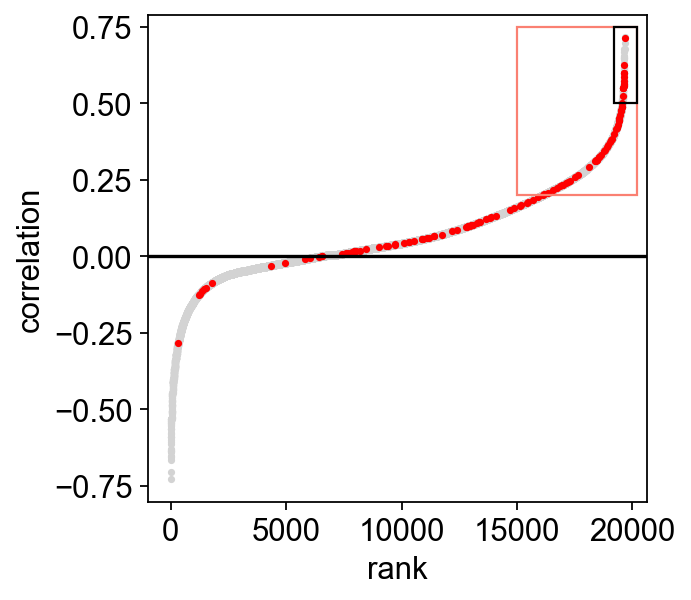

In [40]:
sel=allcors.regulon[::-1]
fig,ax=plt.subplots(figsize=(4,4))
ax.scatter(range(allcors.shape[0]),allcors.correlation[::-1],s=5,marker="o",c="lightgrey",rasterized=True)
ax.scatter(np.arange(allcors.shape[0])[sel],allcors.correlation[::-1][sel],s=5,marker="o",c="red",rasterized=True)
ax.axhline(0,c="k")
ax.add_patch(Rectangle((19200, 0.5), 1000, .25,
             edgecolor = 'black',
             fill=False,
             lw=1,clip_on=False,zorder=100))

ax.add_patch(Rectangle((15000, 0.2), 5200, .55,
             edgecolor = 'salmon',
             fill=False,
             lw=1,clip_on=False,zorder=99))

ax.set_xlabel("rank")
ax.set_ylabel("correlation")
ax.grid(b=False)
plt.savefig("figures/Sox2_chc_corrrank.pdf")

In [41]:
scf.tl.pseudotime(adata_tree,n_jobs=20,n_map=100)

projecting cells onto the principal graph
    mappings: 100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]
    finished (0:00:27) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


In [42]:
scf.tl.test_association(adata_tree,n_jobs=20)

test features for association with the trajectory
    single mapping : 100%|█████████████████████████████████████████████████████████████████| 21676/21676 [01:10<00:00, 306.46it/s]
    found 3129 significant features (0:01:10) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [43]:
g1=allcors.index[allcors.correlation>.5].tolist()
g2=allcors.index[allcors.correlation<-.5].tolist()

In [44]:
scf.tl.fit(adata_tree,g1+g2,n_jobs=20)

fit features associated with the trajectory
    single mapping : 100%|█████████████████████████████████████████████████████████████████████| 159/159 [00:01<00:00, 134.44it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:02) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


In [49]:
adata_tree.obs.seg=adata_tree.obs.seg.astype("category")

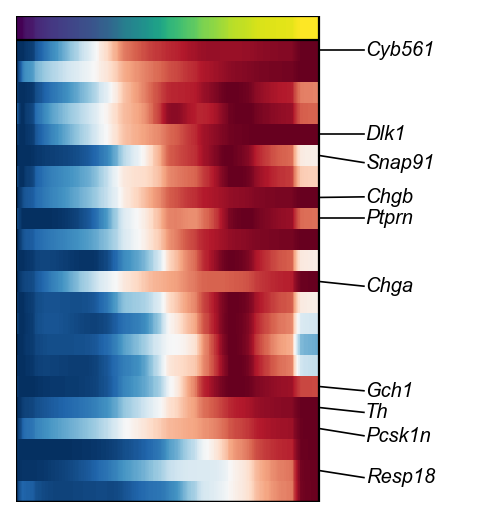

In [50]:
g1=scf.pl.trends(adata_tree,allcors.index[allcors.correlation<-.55],plot_emb=False,ordering="max",return_genes=True,
                 highlight_features=allcors.index[-10:][::-1].tolist(),style="italic")
plt.savefig("figures/Sox2_CHC_anti.pdf")

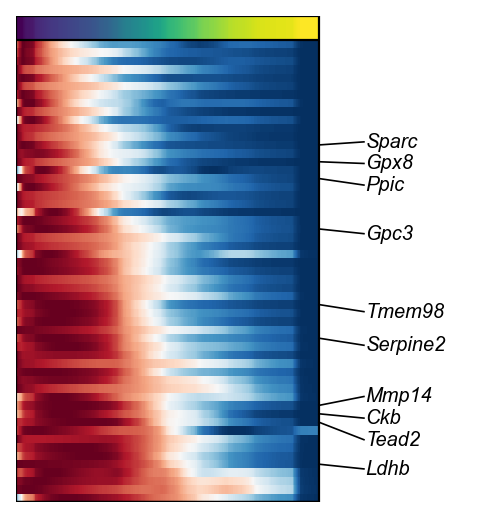

In [51]:
g1=scf.pl.trends(adata_tree,allcors.index[allcors.correlation>.55],plot_emb=False,ordering="max",return_genes=True,
                 highlight_features=allcors.index[:10].tolist(),style="italic")
plt.savefig("figures/SOx2_CHC.pdf")